In [ ]:
import torch

# Load the checkpoint
checkpoint = torch.load(pretrained_model_path, map_location=device)

# Remove "module." prefix from keys
new_state_dict = {k.replace("module.", ""): v for k, v in checkpoint.items()}

# Load the modified state dict into your model
generator.load_state_dict(new_state_dict, strict=False)  # strict=False allows partial loading

# Move to device and set to eval mode
generator.to(device)
generator.eval()


<ipython-input-4-3f1410f642a3>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_model_path, map_location=device)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pretrained Model
generator = Generator().to(device)
checkpoint = torch.load("lsun-generator.pt", map_location=device)

# Modify state_dict to remove "module." prefix (if saved with DataParallel)
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in checkpoint.items():
    new_key = k.replace("module.", "")  # Remove "module." prefix
    new_state_dict[new_key] = v

# Load weights
generator.load_state_dict(new_state_dict, strict=False)

# Freeze early layers and train only the last layers
for param in generator.parameters():
    param.requires_grad = False  # Freeze all layers

# Unfreeze last few layers (fine-tune)
for param in generator.main[-4:].parameters():
    param.requires_grad = True

print(generator)  # Print updated model


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


<ipython-input-5-ae9f88e857ec>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("lsun-generator.pt", map_location=device)


In [ ]:
import torch.nn as nn
class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        """
        Discriminator for GAN/WGAN
        - nc: Number of channels in the input image (3 for RGB, 1 for grayscale)
        - ndf: Number of discriminator feature maps
        """
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),  # Single output (real/fake)
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1)


In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss Function
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for GANs

# Optimizers (Adam)
lr = 0.0002
beta1 = 0.5

# Create instances of Generator and Discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Define Optimizers
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Unfreeze the last few layers for training
for param in generator.parameters():
    param.requires_grad = False  # Freeze all layers

# Unfreeze last few layers
for param in list(generator.children())[-3:]:
    param.requires_grad = True


In [ ]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

batch_size = 64
image_size = 64

# Data Augmentation & Normalization
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1,1]
])

# Load Dataset
dataset = dset.ImageFolder(root="/content/drive/MyDrive/imp docs/sipakmed_dataset", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Check Data
real_batch = next(iter(dataloader))
print("Loaded batch shape:", real_batch[0].shape)


Loaded batch shape: torch.Size([64, 3, 64, 64])


In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update Discriminator
        ############################
        discriminator.zero_grad()

        # Train with real images
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
        real_labels = torch.ones(batch_size, 1, device=device)
        output = discriminator(real_images)
        d_loss_real = criterion(output, real_labels)
        d_loss_real.backward()

        # Train with fake images
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        output = discriminator(fake_images.detach())
        d_loss_fake = criterion(output, fake_labels)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        optimizerD.step()

        ############################
        # (2) Update Generator
        ############################
        generator.zero_grad()
        output = discriminator(fake_images)
        g_loss = criterion(output, real_labels)  # Trick discriminator
        g_loss.backward()
        optimizerG.step()

        # Print progress
        if i % 50 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] Loss_D: {d_loss.item()} Loss_G: {g_loss.item()}")


Epoch [0/100] Batch [0/64] Loss_D: 1.5907211303710938 Loss_G: 3.249614715576172
Epoch [0/100] Batch [50/64] Loss_D: 0.018206248059868813 Loss_G: 15.813671112060547
Epoch [1/100] Batch [0/64] Loss_D: 0.017125291749835014 Loss_G: 11.775531768798828
Epoch [1/100] Batch [50/64] Loss_D: 0.35748177766799927 Loss_G: 4.1584014892578125
Epoch [2/100] Batch [0/64] Loss_D: 0.2974586486816406 Loss_G: 6.762348175048828
Epoch [2/100] Batch [50/64] Loss_D: 0.3057911992073059 Loss_G: 3.359966278076172
Epoch [3/100] Batch [0/64] Loss_D: 0.42822983860969543 Loss_G: 7.221510410308838
Epoch [3/100] Batch [50/64] Loss_D: 0.08605699241161346 Loss_G: 6.268455505371094
Epoch [4/100] Batch [0/64] Loss_D: 2.8322865962982178 Loss_G: 17.171987533569336
Epoch [4/100] Batch [50/64] Loss_D: 1.1635769605636597 Loss_G: 1.1720359325408936
Epoch [5/100] Batch [0/64] Loss_D: 0.33591729402542114 Loss_G: 4.064314842224121
Epoch [5/100] Batch [50/64] Loss_D: 0.45744788646698 Loss_G: 2.241166591644287
Epoch [6/100] Batch [0/

In [ ]:
# Save Models
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

# Load Models
generator.load_state_dict(torch.load("generator.pth", map_location=device))
discriminator.load_state_dict(torch.load("discriminator.pth", map_location=device))


<ipython-input-14-53b7bce58a85>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator.pth", map_location=device))
<ipython-input-1

<All keys matched successfully>

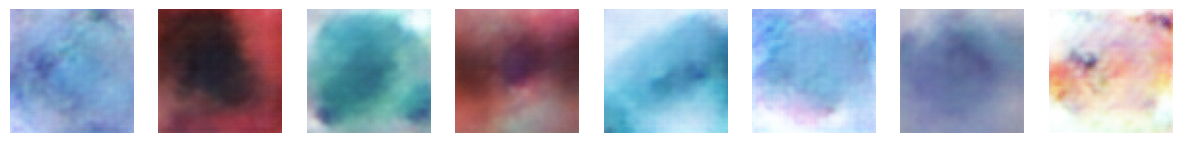

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Set generator to evaluation mode
generator.eval()

# Generate random noise as input
num_samples = 8  # Adjust as needed
noise = torch.randn(num_samples, 100, 1, 1, device=device)  # 100-dimensional latent vector

# Generate images
with torch.no_grad():
    fake_images = generator(noise).detach().cpu()

# Convert from [-1,1] to [0,1] for visualization
fake_images = (fake_images + 1) / 2

# Display generated images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
for i in range(num_samples):
    axes[i].imshow(np.transpose(fake_images[i].numpy(), (1, 2, 0)))  # Convert (C,H,W) to (H,W,C)
    axes[i].axis("off")
plt.show()


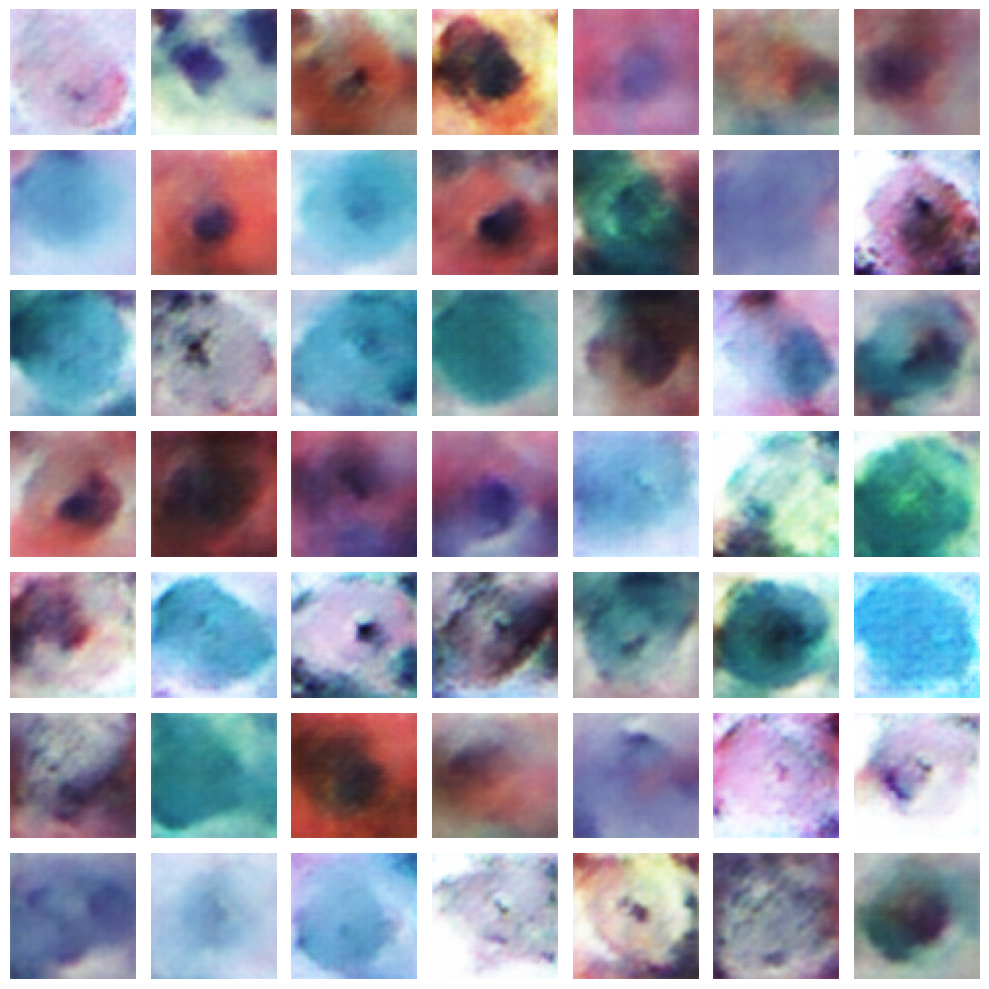

In [ ]:

# Generate 49 random images
num_samples = 49  # 7x7 grid
noise = torch.randn(num_samples, 100, 1, 1, device=device)

# Generate images
with torch.no_grad():
    fake_images = generator(noise).detach().cpu()

# Convert [-1,1] to [0,1] range
fake_images = (fake_images + 1) / 2

# Display the images in a 7x7 grid
fig, axes = plt.subplots(7, 7, figsize=(10, 10))
for i in range(7):
    for j in range(7):
        axes[i, j].imshow(np.transpose(fake_images[i * 7 + j].numpy(), (1, 2, 0)))  # (C,H,W) → (H,W,C)
        axes[i, j].axis("off")
plt.tight_layout()
plt.show()